In [160]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

In [161]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [162]:
cd /content/drive/MyDrive/JOB-HUNTING/CV_NOW/Accenture_REPL_DS/exercise

/content/drive/MyDrive/JOB-HUNTING/CV_NOW/Accenture_REPL_DS/exercise


# Read in raw data

In [163]:
sales = pd.read_csv('data/training_Sales.csv')
traffic = pd.read_csv('data/training_Traffic.csv')

In [164]:
sales.Date = pd.to_datetime(sales.Date)
traffic.Date = pd.to_datetime(traffic.Date)

In [165]:
sales.head(5)

,Date,Value
0,2013-11-07 13:00:00,830
1,2013-11-07 13:15:00,885
2,2013-11-07 13:30:00,938
3,2013-11-07 13:45:00,804
4,2013-11-07 14:00:00,793


In [166]:
traffic.head()

,Date,Value
0,2015-01-01 10:00:00,0
1,2015-01-01 10:15:00,1
2,2015-01-01 10:30:00,4
3,2015-01-01 10:45:00,3
4,2015-01-01 11:00:00,1


In [167]:
print(sales.shape)
print(traffic.shape)

(67058, 2)
(58437, 2)


In [168]:
# missing value


Take a look at the ranges of date and valeus.

In [169]:
print(sales.Date.min())
print(sales.Date.max())
print(sales.Value.min())
print(sales.Value.max())

2013-11-07 13:00:00
2018-05-06 19:00:00
0
6435


In [170]:
(sales.Date.max() - sales.Date.min())/pd.Timedelta(1,'d')

1641.25

In [171]:
(sales.Date.max() - sales.Date.min())/pd.Timedelta(15,'m')/(4*24)

1641.25

In [172]:
(traffic.Date.max() - traffic.Date.min())/pd.Timedelta(15,'m')/(4*24)

1221.4583333333333

In [173]:
print(traffic.Date.min())
print(traffic.Date.max())
print(traffic.Value.min())
print(traffic.Value.max())

2015-01-01 10:00:00
2018-05-06 21:00:00
0
39


The ranges make sense, e.g., 6435 = $64.35

In [174]:
#string--> datetime
sales['Date'] = pd.to_datetime(sales.Date)
traffic['Date'] = pd.to_datetime(traffic.Date)

# Check missing values

This sectino add full range timestamp columns for every 15 min, and then every 1 hour. After this section, all timestamp are **full range timestamp** except column 'time_only_org' with nan values.

## sales

In [175]:
sales.sort_values(by = 'Date', inplace = True)
time_span_sales = sales.Date.iloc[-1] - sales.Date.iloc[0] + pd.Timedelta(15, "m")
num_rows = int(time_span_sales/pd.Timedelta(15, "m"))
print('According to the data range from sale table, we should have {num_rows} rows'.format(num_rows=num_rows))
print('we acutally have: {} rows'.format(sales.shape[0]))
print('Percentage of missing values: {}'.format(1-sales.shape[0]/num_rows))

According to the data range from sale table, we should have 157561 rows
we acutally have: 67058 rows
Percentage of missing values: 0.5743997562848675


In [176]:
sales['time_only_org'] = sales.Date.dt.time # this column have nan after 'join'
import seaborn as sns

In [177]:
# expand table 'sales' by merging with full time range, get ready  for missing value imputation, also preparing for correct calculation of ACF and PACF later
time_start = sales.Date.iloc[0]
time_delta_15min = pd.Timedelta(15, "m")
time_array = np.empty(num_rows, dtype = pd.Timestamp)
time_array[0] =  time_start
for i in range(1,num_rows):
  time_array[i] = time_array[i-1]+time_delta_15min
temp_T_full_time = pd.DataFrame({'Date':time_array})
sales = sales.merge(temp_T_full_time, on = 'Date', how = 'right')
# add column time_only for all time
sales['time_only_all'] = sales.Date.dt.time # this column has no nan, containing consecutive 15-min range

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


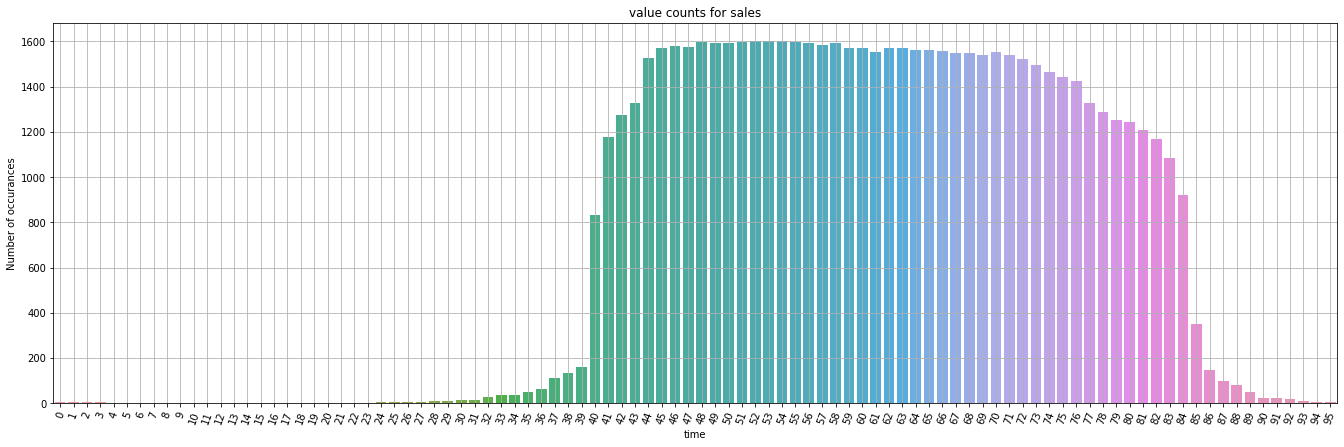

In [178]:
# use count to plot bar plot, aggregate with mean, std, count does not count nan
temp_bar = (sales.groupby(['time_only_all'], as_index = False).agg(OrderedDict(
                                                                [('Value',['count','mean','std']),
                                                                 ])))
temp_bar.columns = ['time_only_all','valid_value_count','mean_value','std_value']

sns.barplot(temp_bar.time_only_all, temp_bar.valid_value_count)
plt.title("value counts for sales")
plt.ylabel("Number of occurances")
plt.xlabel('time')
fig = plt.gcf()
fig.set_size_inches(23, 7)
ax = plt.gca()
# plt.draw()
ax.set_xticklabels(ax.get_xticks(), rotation = 70)
plt.grid()
plt.show()

In [179]:
print("We have >=1200 values from {} am o'clock to {}".format(41 * 15/60, 82*15/60))
print("We have >=800 values from {} am o'clock to {}".format(40 * 15/60, 84*15/60))

We have >=1200 values from 10.25 am o'clock to 20.5
We have >=800 values from 10.0 am o'clock to 21.0


Considering night hours are extreamly less active than daily hours. It seems to me I can assume we have 0 sales for thoes missing hours. Further inspection on the time series plots provided more proof for this assumption.   I think if we impute them with 0. The model performance probabily will not be affected too much. I will start by imputing missing value with 0. This can be further verified by the fact that both the ACF and PACF plot makes sense by assuming the mising data to be zero.

In [180]:
# sanity check on values for each time segment
pd.set_option('display.max_rows', None)
temp_bar.iloc[36:63]

,time_only_all,valid_value_count,mean_value,std_value
36,09:00:00,64,829.093750,135.305031
37,09:15:00,112,809.803571,101.300093
38,09:30:00,136,814.213235,102.674849
39,09:45:00,163,808.625767,108.798664
40,10:00:00,833,750.777911,80.587267
41,10:15:00,1176,770.355442,80.995978
42,10:30:00,1275,786.272941,82.621097
43,10:45:00,1330,800.340602,84.949295
44,11:00:00,1525,803.484590,93.298307
45,11:15:00,1572,806.893766,93.539806


## traffic

In [181]:
traffic.head()

,Date,Value
0,2015-01-01 10:00:00,0
1,2015-01-01 10:15:00,1
2,2015-01-01 10:30:00,4
3,2015-01-01 10:45:00,3
4,2015-01-01 11:00:00,1


In [182]:
traffic.sort_values(by = 'Date', inplace = True)
time_span_sales = traffic.Date.iloc[-1] - traffic.Date.iloc[0] + pd.Timedelta(15, "m")
num_rows = int(time_span_sales/pd.Timedelta(15, "m"))
print('According to the data range from traffic table, we should have {num_rows} rows'.format(num_rows=num_rows))
print('we acutally have: {} rows'.format(traffic.shape[0]))
print('Percentage of missing values: {}'.format(1-traffic.shape[0]/num_rows))

According to the data range from traffic table, we should have 117261 rows
we acutally have: 58437 rows
Percentage of missing values: 0.5016501650165017


In [183]:
traffic['time_only_org'] = traffic.Date.dt.time # this column have nan after 'join'
import seaborn as sns

In [184]:
# expand table 'traffic' by merging with full time range, get ready  for missing value imputation, also preparing for correct calculation of ACF and PACF later
time_start = traffic.Date.iloc[0]
time_delta_15min = pd.Timedelta(15, "m")
time_array = np.empty(num_rows, dtype = pd.Timestamp)
time_array[0] =  time_start
for i in range(1,num_rows):
  time_array[i] = time_array[i-1]+time_delta_15min
temp_T_full_time = pd.DataFrame({'Date':time_array})
traffic = traffic.merge(temp_T_full_time, on = 'Date', how = 'right')
# add column time_only for all time
traffic['time_only_all'] = traffic.Date.dt.time # thsi column has no nan, containing consecutive 15-min range

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


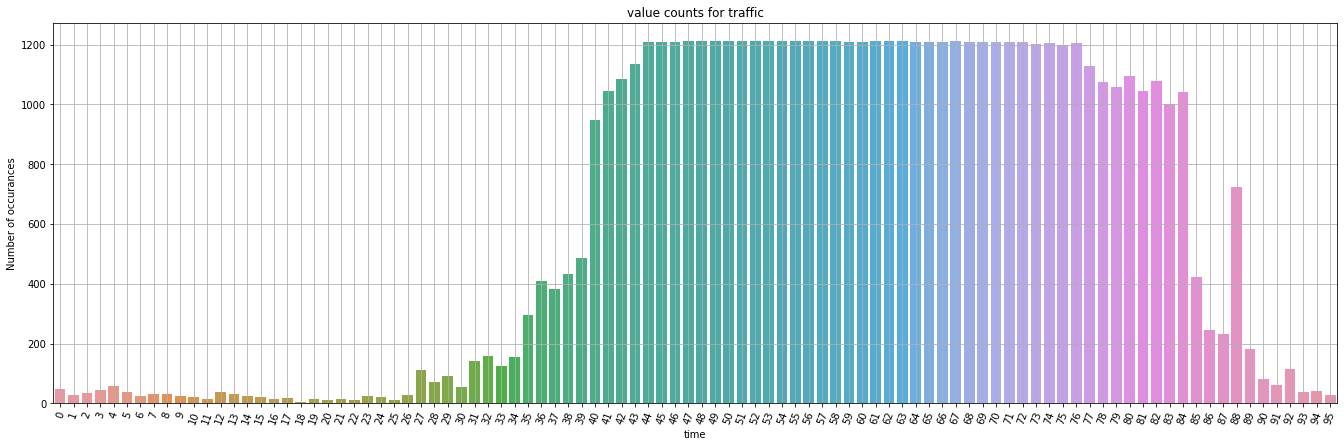

In [185]:
# use count to plot bar plot, aggregate with mean, std, count does not count nan sales
temp_bar = (traffic.groupby(['time_only_all'], as_index = False).agg(OrderedDict(
                                                                [('Value',['count','mean','std']),
                                                                 ])))
temp_bar.columns = ['time_only_all','valid_value_count','mean_value','std_value']

sns.barplot(temp_bar.time_only_all, temp_bar.valid_value_count)
plt.title("value counts for traffic")
plt.ylabel("Number of occurances")
plt.xlabel('time')
fig = plt.gcf()
fig.set_size_inches(23, 7)
ax = plt.gca()
# plt.draw()
ax.set_xticklabels(ax.get_xticks(), rotation = 70)
plt.grid()
plt.show()

In [186]:
# sanity check on values for each time segment
pd.set_option('display.max_rows', None)
temp_bar.iloc[36:63]

,time_only_all,valid_value_count,mean_value,std_value
36,09:00:00,411,0.776156,1.986176
37,09:15:00,383,0.981723,2.285209
38,09:30:00,433,0.884527,2.223728
39,09:45:00,487,0.728953,2.343111
40,10:00:00,949,0.889357,1.900306
41,10:15:00,1046,1.501912,2.388068
42,10:30:00,1085,2.075576,2.528765
43,10:45:00,1135,2.493392,2.728726
44,11:00:00,1207,3.058824,2.783037
45,11:15:00,1210,3.563636,3.075773


## Check amount of zero entries

In [187]:
print('Amount of zero entries in sales',sum(sales.Value==0))
print('Amount of zero entries traffic',sum(traffic.Value==0))

Amount of zero entries in sales 1
Amount of zero entries traffic 6169


Another strategy could be that we fill missing value with our trained models.

# Adding auxilary datatime columns for the following processing 

This is for later aggregation and may be useful for feature engineering. The added columns are: hour, day, month, year, num_of_days, num_of_weeks. Among them, hour, day, month and year are still in datetime format for the convenience of data visulization.

In [188]:
sales.head()

,Date,Value,time_only_org,time_only_all
0,2013-11-07 13:00:00,830.0,13:00:00,13:00:00
1,2013-11-07 13:15:00,885.0,13:15:00,13:15:00
2,2013-11-07 13:30:00,938.0,13:30:00,13:30:00
3,2013-11-07 13:45:00,804.0,13:45:00,13:45:00
4,2013-11-07 14:00:00,793.0,14:00:00,14:00:00


In [189]:
sales['hour'] = sales.Date.dt.floor('h')
traffic['hour'] = traffic.Date.dt.floor('h')

sales['day'] = sales.Date.dt.floor('d')
traffic['day'] = traffic.Date.dt.floor('d')

sales['month'] = sales.Date.dt.to_period('m').dt.to_timestamp()
traffic['month'] = traffic.Date.dt.to_period('m').dt.to_timestamp()

sales['year'] = sales.Date.dt.to_period('y').dt.to_timestamp()
traffic['year'] = traffic.Date.dt.to_period('y').dt.to_timestamp()

# week
sales['num_of_hours']= (sales.hour-sales.hour.iloc[0]).apply(lambda x: int(x/pd.Timedelta(1, "h")))
sales['num_of_days']= (sales.day-sales.day.iloc[0]).dt.days
sales['num_of_weeks'] = sales['num_of_days']//7

traffic['num_of_hours']= (traffic.hour-traffic.hour.iloc[0]).apply(lambda x: int(x/pd.Timedelta(1, "h")))
traffic['num_of_days']= (traffic.day-traffic.day.iloc[0]).dt.days
traffic['num_of_weeks'] = traffic['num_of_days']//7

In [190]:
sales.head(10)

,Date,Value,time_only_org,time_only_all,hour,day,month,year,num_of_hours,num_of_days,num_of_weeks
0,2013-11-07 13:00:00,830.0,13:00:00,13:00:00,2013-11-07 13:00:00,2013-11-07,2013-11-01,2013-01-01,0,0,0
1,2013-11-07 13:15:00,885.0,13:15:00,13:15:00,2013-11-07 13:00:00,2013-11-07,2013-11-01,2013-01-01,0,0,0
2,2013-11-07 13:30:00,938.0,13:30:00,13:30:00,2013-11-07 13:00:00,2013-11-07,2013-11-01,2013-01-01,0,0,0
3,2013-11-07 13:45:00,804.0,13:45:00,13:45:00,2013-11-07 13:00:00,2013-11-07,2013-11-01,2013-01-01,0,0,0
4,2013-11-07 14:00:00,793.0,14:00:00,14:00:00,2013-11-07 14:00:00,2013-11-07,2013-11-01,2013-01-01,1,0,0
5,2013-11-07 14:15:00,NaN,NaN,14:15:00,2013-11-07 14:00:00,2013-11-07,2013-11-01,2013-01-01,1,0,0
6,2013-11-07 14:30:00,730.0,14:30:00,14:30:00,2013-11-07 14:00:00,2013-11-07,2013-11-01,2013-01-01,1,0,0
7,2013-11-07 14:45:00,727.0,14:45:00,14:45:00,2013-11-07 14:00:00,2013-11-07,2013-11-01,2013-01-01,1,0,0
8,2013-11-07 15:00:00,NaN,NaN,15:00:00,2013-11-07 15:00:00,2013-11-07,2013-11-01,2013-01-01,2,0,0
9,2013-11-07 15:15:00,NaN,NaN,15:15:00,2013-11-07 15:00:00,2013-11-07,2013-11-01,2013-01-01,2,0,0


In [191]:
traffic.head()

,Date,Value,time_only_org,time_only_all,hour,day,month,year,num_of_hours,num_of_days,num_of_weeks
0,2015-01-01 10:00:00,0.0,10:00:00,10:00:00,2015-01-01 10:00:00,2015-01-01,2015-01-01,2015-01-01,0,0,0
1,2015-01-01 10:15:00,1.0,10:15:00,10:15:00,2015-01-01 10:00:00,2015-01-01,2015-01-01,2015-01-01,0,0,0
2,2015-01-01 10:30:00,4.0,10:30:00,10:30:00,2015-01-01 10:00:00,2015-01-01,2015-01-01,2015-01-01,0,0,0
3,2015-01-01 10:45:00,3.0,10:45:00,10:45:00,2015-01-01 10:00:00,2015-01-01,2015-01-01,2015-01-01,0,0,0
4,2015-01-01 11:00:00,1.0,11:00:00,11:00:00,2015-01-01 11:00:00,2015-01-01,2015-01-01,2015-01-01,1,0,0


# Aggregate data ('hour','day','week', 'month', 'year')

The data aggreagation is for the easiness of discoverying data seasonality details.

In [192]:
# group by  'hour' sales traffic, # can use min_count=4 as parameter of sum to not count nan value
hourly_sales = sales.groupby(['hour'], as_index = False).agg(OrderedDict([('Value','sum'),
                                                                          ('num_of_hours','min'),
                                                                          ('num_of_weeks','min')
                                                                          ])) 
hourly_sales.sort_values(by = 'hour',inplace = True)

hourly_traffic = traffic.groupby(['hour'], as_index = False).agg(OrderedDict([('Value','sum'),
                                                                              ('num_of_hours','min'),
                                                                              ('num_of_weeks','min')
                                                                            ])) 
hourly_traffic.sort_values(by = 'hour',inplace = True)

# group by 'day'
daily_sales = sales.groupby(['day'], as_index = False).agg(OrderedDict([('Value','sum')]))
daily_sales.sort_values(by = 'day',inplace = True)
daily_traffic = traffic.groupby(['day'], as_index = False).agg(OrderedDict([('Value','sum')]))
daily_traffic.sort_values(by = 'day',inplace = True)
# group by 'week'
weekly_sales = sales.groupby(['num_of_weeks'], as_index = False).agg(OrderedDict([('Value','sum')]))
weekly_sales.sort_values(by = 'num_of_weeks',inplace = True)
weekly_traffic = traffic.groupby(['num_of_weeks'], as_index = False).agg(OrderedDict([('Value','sum')]))
weekly_traffic.sort_values(by = 'num_of_weeks',inplace = True)
# group by 'month'
monthly_sales = sales.groupby(['month'], as_index = False).agg(OrderedDict([('Value','sum')]))
monthly_sales.sort_values(by = 'month',inplace = True)
monthly_traffic = traffic.groupby(['month'], as_index = False).agg(OrderedDict([('Value','sum')]))
monthly_traffic.sort_values(by = 'month',inplace = True)
# group by 'year'
yearly_sales = sales.groupby(['year'], as_index = False).agg(OrderedDict([('Value','sum')]))
yearly_sales.sort_values(by = 'year',inplace = True)
yearly_traffic = traffic.groupby(['year'], as_index = False).agg(OrderedDict([('Value','sum')]))
yearly_traffic.sort_values(by = 'year',inplace = True)

In [193]:
print('sales range',hourly_sales.hour.iloc[0],'----',hourly_sales.hour.iloc[-1])
print('traffic range',hourly_traffic.hour.iloc[0],'----',hourly_traffic.hour.iloc[-1])

sales range 2013-11-07 13:00:00 ---- 2018-05-06 19:00:00
traffic range 2015-01-01 10:00:00 ---- 2018-05-06 21:00:00


Prepare partial sales table for the convience of plotting cross correlation

In [194]:
hourly_sales_partial = hourly_sales[(hourly_sales.hour>=hourly_traffic.hour.iloc[0])]
daily_sales_partial = daily_sales[(daily_sales.day>=daily_traffic.day.iloc[0])]

In [195]:
# week
sales['num_of_hours']= (sales.hour-sales.hour.iloc[0]).apply(lambda x: int(x/pd.Timedelta(1, "h")))
sales['num_of_days']= (sales.day-sales.day.iloc[0]).dt.days
sales['num_of_weeks'] = sales['num_of_days']//7

traffic['num_of_hours']= (traffic.hour-traffic.hour.iloc[0]).apply(lambda x: int(x/pd.Timedelta(1, "h")))
traffic['num_of_days']= (traffic.day-traffic.day.iloc[0]).dt.days
traffic['num_of_weeks'] = traffic['num_of_days']//7

In [196]:
weekly_sales.head()

,num_of_weeks,Value
0,0,223513.0
1,1,215608.0
2,2,228981.0
3,3,216698.0
4,4,272244.0


In [197]:
weekly_traffic.head()

,num_of_weeks,Value
0,0,2024.0
1,1,1393.0
2,2,1315.0
3,3,1155.0
4,4,994.0


In [198]:
sum(hourly_sales.Value==0)

20571

We have significant amount of zeros for hourly sales.Why?

In [199]:
sales.to_csv('data/explored_sales.csv',index=False)
traffic.to_csv('data/explored_traffic.csv',index=False)

In [200]:
hourly_sales.head()

,hour,Value,num_of_hours,num_of_weeks
0,2013-11-07 13:00:00,3457.0,0,0
1,2013-11-07 14:00:00,2250.0,1,0
2,2013-11-07 15:00:00,0.0,2,0
3,2013-11-07 16:00:00,729.0,3,0
4,2013-11-07 17:00:00,0.0,4,0


In [201]:
hourly_sales.to_csv('data/hourly_sales.csv',index=False)
hourly_traffic.to_csv('data/hourly_traffic.csv',index=False)
daily_sales.to_csv('data/daily_sales.csv',index=False)
daily_traffic.to_csv('data/daily_traffic.csv',index=False)
weekly_sales.to_csv('data/weekly_sales.csv',index=False)
weekly_traffic.to_csv('data/weekly_traffic.csv',index=False)
monthly_sales.to_csv('data/monthly_sales.csv',index=False)
monthly_traffic.to_csv('data/monthly_traffic.csv',index=False)
yearly_sales.to_csv('data/yearly_sales.csv',index=False)
yearly_traffic.to_csv('data/yearly_traffic.csv',index=False)

hourly_sales_partial.to_csv('data/hourly_sales_partial.csv', index=False)
daily_sales_partial.to_csv('data/daily_sales_partial.csv', index=False)

In [202]:
daily_sales.head()

,day,Value
0,2013-11-07,8825.0
1,2013-11-08,48626.0
2,2013-11-09,41263.0
3,2013-11-10,32212.0
4,2013-11-11,32324.0


In [203]:
daily_traffic.head()

,day,Value
0,2015-01-01,302.0
1,2015-01-02,458.0
2,2015-01-03,449.0
3,2015-01-04,297.0
4,2015-01-05,188.0


In [204]:
hourly_sales.head()

,hour,Value,num_of_hours,num_of_weeks
0,2013-11-07 13:00:00,3457.0,0,0
1,2013-11-07 14:00:00,2250.0,1,0
2,2013-11-07 15:00:00,0.0,2,0
3,2013-11-07 16:00:00,729.0,3,0
4,2013-11-07 17:00:00,0.0,4,0


In [205]:
weekly_sales.head()

,num_of_weeks,Value
0,0,223513.0
1,1,215608.0
2,2,228981.0
3,3,216698.0
4,4,272244.0


优劣势：
ARIMA：很好的利用correlation，但是很多0怎么处理？
linear regression:很好的利用了seanality,能够很好的处理0 (半夜的)

In [206]:
sales.head()

,Date,Value,time_only_org,time_only_all,hour,day,month,year,num_of_hours,num_of_days,num_of_weeks
0,2013-11-07 13:00:00,830.0,13:00:00,13:00:00,2013-11-07 13:00:00,2013-11-07,2013-11-01,2013-01-01,0,0,0
1,2013-11-07 13:15:00,885.0,13:15:00,13:15:00,2013-11-07 13:00:00,2013-11-07,2013-11-01,2013-01-01,0,0,0
2,2013-11-07 13:30:00,938.0,13:30:00,13:30:00,2013-11-07 13:00:00,2013-11-07,2013-11-01,2013-01-01,0,0,0
3,2013-11-07 13:45:00,804.0,13:45:00,13:45:00,2013-11-07 13:00:00,2013-11-07,2013-11-01,2013-01-01,0,0,0
4,2013-11-07 14:00:00,793.0,14:00:00,14:00:00,2013-11-07 14:00:00,2013-11-07,2013-11-01,2013-01-01,1,0,0


In [207]:
sum(sales.Value[sales.day == pd.to_datetime('2014-12-31')].isnull())

96

In [208]:
hourly_sales.head()

,hour,Value,num_of_hours,num_of_weeks
0,2013-11-07 13:00:00,3457.0,0,0
1,2013-11-07 14:00:00,2250.0,1,0
2,2013-11-07 15:00:00,0.0,2,0
3,2013-11-07 16:00:00,729.0,3,0
4,2013-11-07 17:00:00,0.0,4,0


In [209]:
hourly_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39391 entries, 0 to 39390
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   hour          39391 non-null  datetime64[ns]
 1   Value         39391 non-null  float64       
 2   num_of_hours  39391 non-null  int64         
 3   num_of_weeks  39391 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 1.5 MB


In [210]:
print(min(hourly_sales.hour))
print(max(hourly_sales.hour))

2013-11-07 13:00:00
2018-05-06 19:00:00


In [211]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157561 entries, 0 to 157560
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           157561 non-null  datetime64[ns]
 1   Value          67058 non-null   float64       
 2   time_only_org  67058 non-null   object        
 3   time_only_all  157561 non-null  object        
 4   hour           157561 non-null  datetime64[ns]
 5   day            157561 non-null  datetime64[ns]
 6   month          157561 non-null  datetime64[ns]
 7   year           157561 non-null  datetime64[ns]
 8   num_of_hours   157561 non-null  int64         
 9   num_of_days    157561 non-null  int64         
 10  num_of_weeks   157561 non-null  int64         
dtypes: datetime64[ns](5), float64(1), int64(3), object(2)
memory usage: 14.4+ MB


In [212]:
sales.day.iloc[0]

Timestamp('2013-11-07 00:00:00')